In [3]:
import numpy as np
import scipy as sp
import cvxpy as cp

from models import Model
from methods import intermediate, salim
from utils import plot_logs, plot_logs_pd

from typing import List

from tqdm import tqdm
from matplotlib import pyplot as plt

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

# Numerical Experiment

There we will use a model from Example 2 in paper ["Decentralized Proximal Method of Multipliers for Convex Optimization with Coupled Constraints", 2023](https://arxiv.org/pdf/2310.15596.pdf), but with L2 borm instead of L1, universal regularization parameter for all nodes, without right part of equality constraints and without inequality constraints.

This problem is also similar to Example in paper ["Decentralized Strongly-Convex Optimization with Affine Constraints: Primal and Dual Approaches"](https://arxiv.org/pdf/2207.04555.pdf), but there are distinct variables on each node.

$$ \min_{\mathbf{x}} F(\mathbf{x}) = \sum\limits_{i=1}^{n} \Big( \frac{1}{2}\| C_i x_i - d_i \|_2^{2} + \frac{\theta}{2} \| x_i \|_2^2 \Big) $$
$$ \textrm{s.t.} \quad \sum\limits_{i=1}^{n} A_i x_i = 0 $$ 
We can calculate function, gradient and hessian using
$$ \mathbf{C} = \mathrm{diag}\left(C_1, \ldots, C_n \right), \quad \mathbf{d} = \mathrm{col}\left( d_1, \ldots, d_n \right) $$
as
$$ F(\mathbf{x}) = \frac{1}{2}\| \mathbf{C} \mathbf{x} - \mathbf{d} \|_2^{2} + \frac{\theta}{2} \| \mathbf{x} \|_2^2 $$
$$ \nabla F(\mathbf{x}) = \mathbf{C}^\top \mathbf{C} \mathbf{x} - \mathbf{C}^\top \mathbf{d} + \theta \mathbf{x} $$
$$ \nabla^2 F(\mathbf{x}) = \mathbf{C}^\top \mathbf{C} + \theta I_{d} $$

# Khamisov reformulation + Augmentation

In [8]:
class ExampleModel(Model):
    """
    Model from Example 2 in paper
    "Decentralized Proximal Method of Multipliers 
    for Convex Optimization with Coupled Constraints", 2023.
    """
    def __init__(self, 
                 num_nodes: int, 
                 num_cons: int, 
                 dims: List[int], 
                 graph: str = 'ring', 
                 edge_prob: float = None, 
                 nu: float = None) -> None:
        super().__init__(num_nodes, num_cons, dims, graph, edge_prob, nu)
        
        # set parameters for function
        self.C = [np.random.rand(self.dims[i], self.dims[i]) for i in range(self.n)] # C_1, ..., C_n
        self.d = [np.random.rand(self.dims[i]) for i in range(self.n)] # d_1, ..., d_n
        self.theta = 1e-3 # regularization parameter
        
        self.bC = sp.linalg.block_diag(*self.C) # bC = diag(C_1, ... C_n)
        self.bd = np.hstack(self.d) # bd = col(d_1, ..., d_n)
        
        self._bCT_bC = None # used in grad_F and hess_F
        self._bCT_bd = None # used in grad_F

        self.solution = self._get_solution()

        
    @property
    def bCT_bC(self) -> np.ndarray:
        if self._bCT_bC is None:
            self._bCT_bC = self.bC.T @ self.bC
        return self._bCT_bC

    @property
    def bCT_bd(self) -> np.ndarray:
        if self._bCT_bd is None:
            self._bCT_bd = self.bC.T @ self.bd
        return self._bCT_bd
    
    def F(self, bx):
        """
        Args:
            bx: np.ndarray - Vector of primal variables.
        Returns:
            Function value at point bx.
        """
        a = self.bC @ bx - self.bd
        return 1/2 * (a.T @ a + self.theta * bx.T @ bx)
    
    
    def grad_F(self, bx):
        """
        Args:
            bx: np.ndarray - Vector of primal variables.
        Returns:
            Function gradient at point bx.
        """
        return self.bCT_bC @ bx - self.bCT_bd + self.theta * bx
    
    
    def hess_F(self, bx: np.ndarray = None):
        """
        Args:
            bx: np.ndarray = None - Vector of primal variables.
        Returns:
            Function hessian at point bx.
        """
        return self.bCT_bC + self.theta * np.identity(self.dim)
    
    
    def _get_solution(self):
        """
        Returns:
            xz_star = np.hstack((x.value, z.value)): Solution.
            prob.value: Function value at solution.
        """
        x = cp.Variable(self.dim)
        z = cp.Variable(self.n * self.m)
        
        objective = cp.Minimize(
            1/2 * cp.sum_squares(self.bC @ x - self.bd) 
            + self.theta/2 * cp.sum_squares(x)
        )
        
        constraints = [self.bA_prime @ x + self.bW @ z - self.bb_prime == 0]
        
        prob = cp.Problem(objective, constraints)
        prob.solve()
        
        return np.hstack((x.value, z.value)), prob.value

In [23]:
np.random.seed(307)

num_nodes = 20
num_cons = 3
dims = [3 for _ in range(num_nodes)]
graph = 'erdos-renyi'

model = ExampleModel(
    num_nodes=num_nodes,
    num_cons=num_cons,
    dims=dims,
    graph=graph,
    edge_prob=0.5
)

In [24]:
_, sigma, _ = np.linalg.svd(model.bB)
sigma_squared = sigma ** 2
print(sigma_squared[::-1][:5])

lambdas = np.linalg.eigvalsh(model.bB.T @ model.bB)
print(lambdas[:5])

[8.90406926e-32 1.20978984e-30 4.92175056e-29 8.92615505e-01
 9.08528741e-01]
[-5.53334156e-15 -1.88336755e-15  3.64288374e-15  8.92615505e-01
  9.08528741e-01]


## Intermediate algorithm

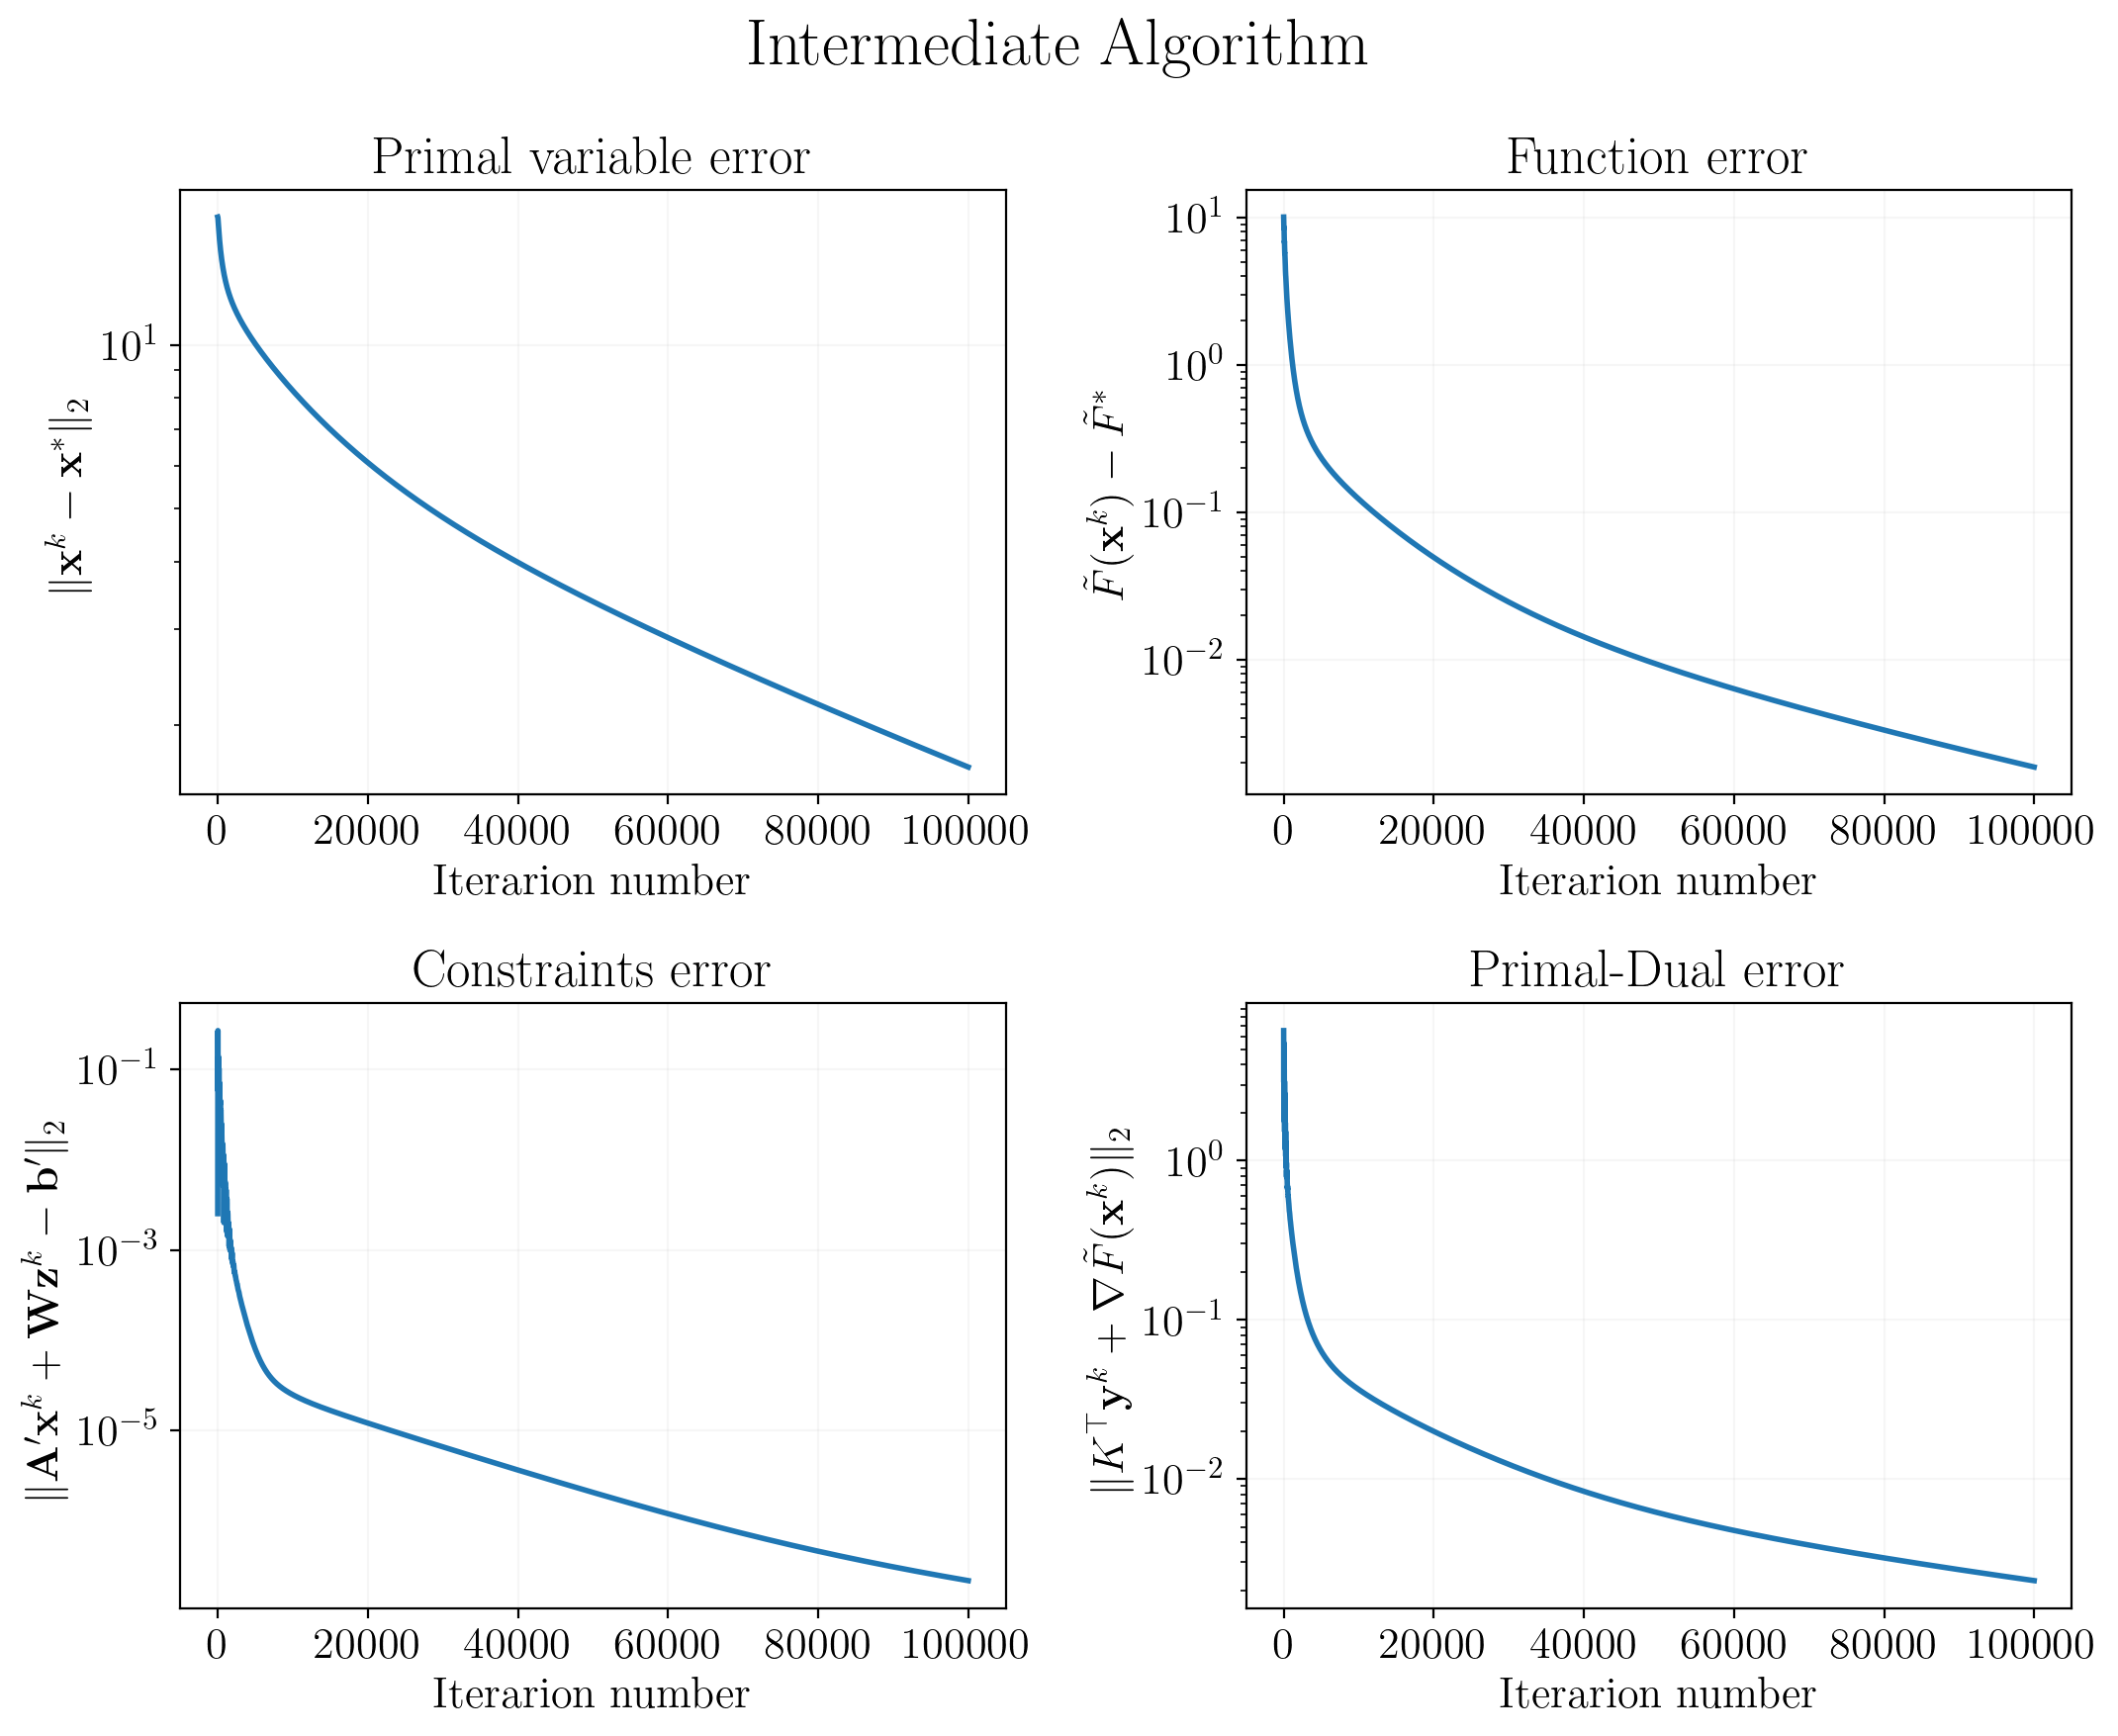

In [25]:
x_f, x_err, F_err, cons_err, primal_dual_err = intermediate(num_steps=10**5, model=model)
plot_logs_pd(x_err, F_err, cons_err, primal_dual_err, "Intermediate Algorithm")

## Algorithm 1

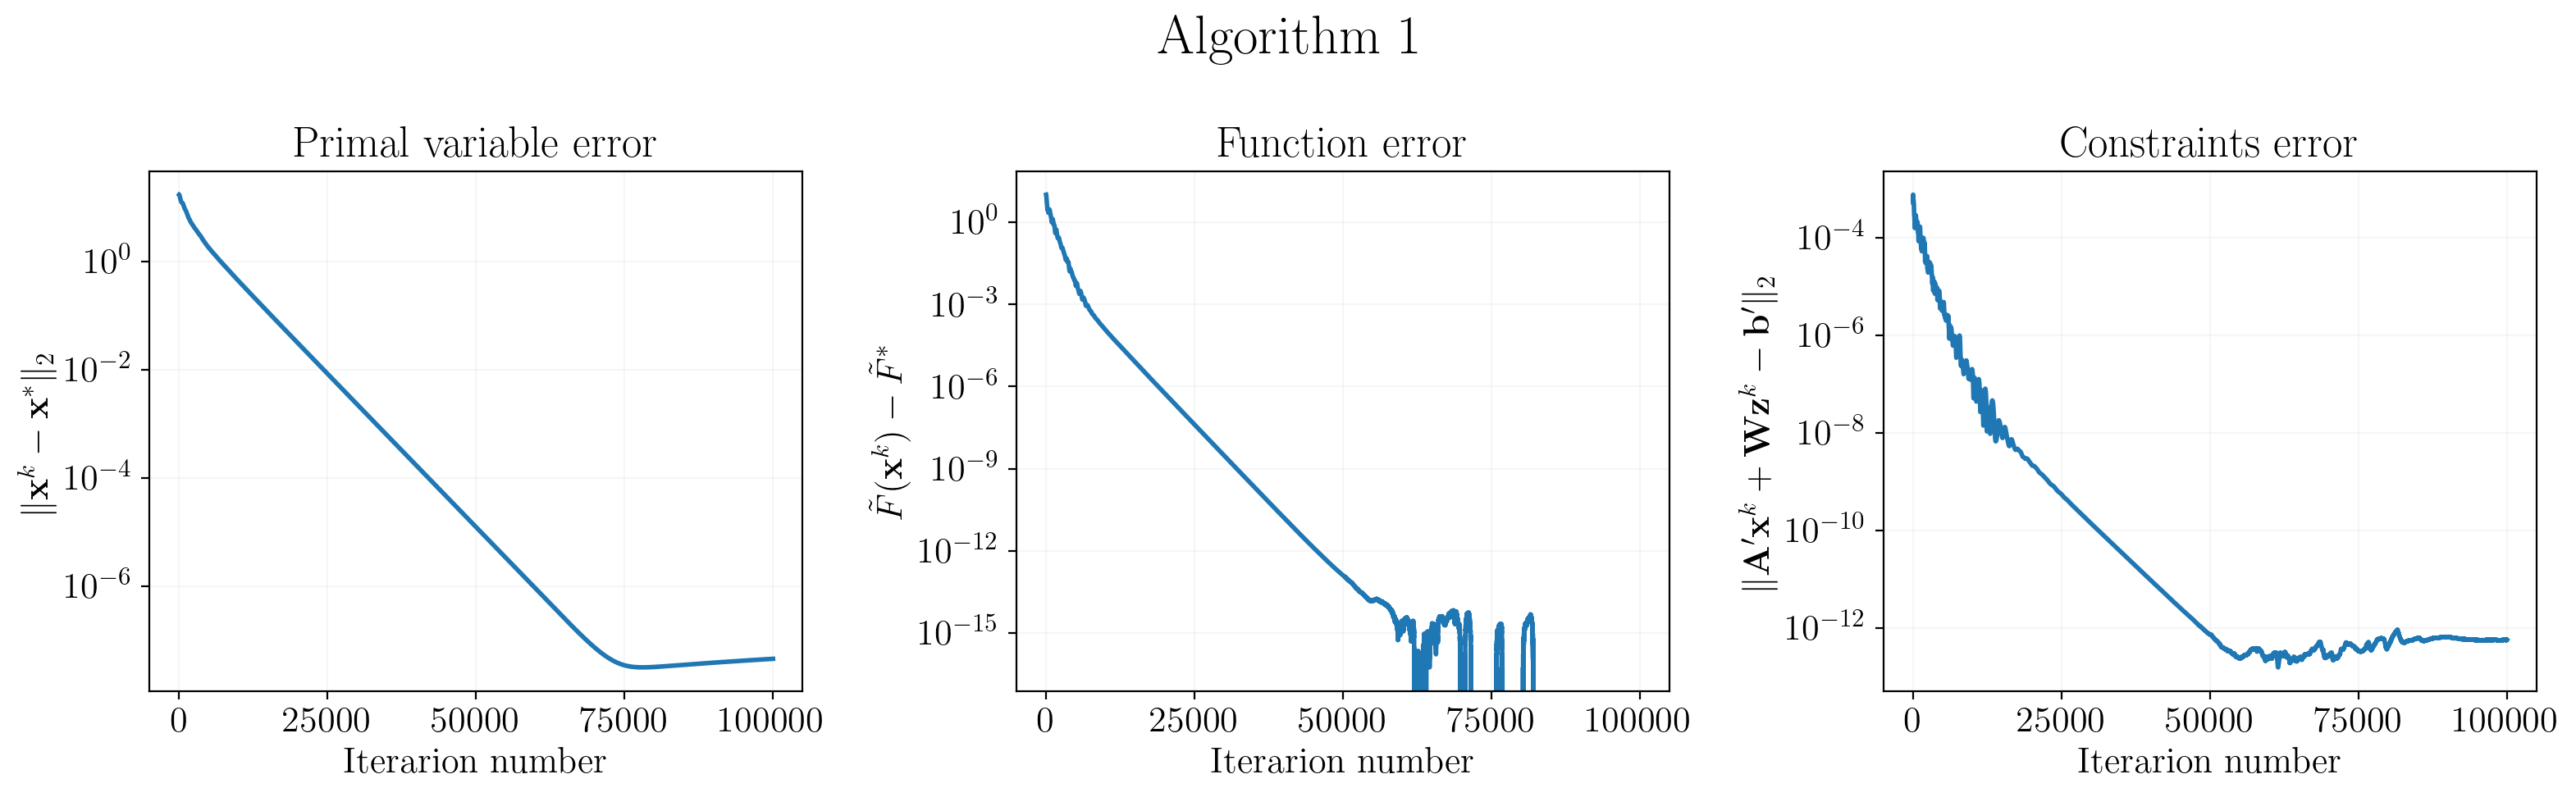

In [32]:
x_f, x_err, F_err, cons_err = salim(num_steps=10**5, model=model)
plot_logs(x_err, F_err, cons_err, "Algorithm 1")